In [1]:
#Core Python, Pandas, and kaldi_io
import numpy as np
import pandas as pd
import string
from collections import Counter
import random
import kaldi_io

#Scikit
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances,average_precision_score
from sklearn.metrics.pairwise import pairwise_kernels
from scipy import stats
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA

#Plotting
from matplotlib import pyplot as plt
import seaborn as sns



#Torch and utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader,random_split,ConcatDataset
import torch.cuda as cutorch

#Import User defined classes
from data_helpers import DataHelper
from models import SimpleNet, SimpleNet_with_dropout 
from siamese_dataset import SiameseTriplets
from train_test_helpers import accuracy,train_model,evaluate_model,evaluate_model_paper,test_model,plot_learning_curves
from ami_clean_dataset import AMI_clean_dataset
from ami_noisy_dataset import AMI_noisy_dataset

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [2]:
num_examples = np.Inf
#Load Noisy Data
train_ds = AMI_noisy_dataset(num_examples = num_examples, split_set = "train", data_filepath = "", char_threshold = 5, frequency_bounds = (0,np.Inf), cluster = False)
val_ds = AMI_noisy_dataset(num_examples = num_examples, split_set = "val", data_filepath = "", char_threshold = 5, frequency_bounds = (0,np.Inf), cluster = False)
test_ds = AMI_noisy_dataset(num_examples = num_examples, split_set = "test", data_filepath = "", char_threshold = 5, frequency_bounds = (0,np.Inf), cluster = False)
#DataLoaders
#train_dl = DataLoader(train_ds, batch_size=bs, pin_memory = True, shuffle = True, drop_last = True)
#val_dl = DataLoader(val_ds, batch_size=bs, pin_memory = True, shuffle = True, drop_last = True)
#test_dl = DataLoader(test_ds, batch_size=bs, pin_memory = True, shuffle = True, drop_last = True)

Length before filtering on char length 169387
Length after filtering on char length 80823
Length before filtering on frequency_bounds 80823
Finished Loading the Data, 80823 examples
Number of Unique words  8607
torch.Size([48493, 40, 100]) torch.Size([16165, 40, 100]) torch.Size([16165, 40, 100])
Length before filtering on char length 169387
Length after filtering on char length 80823
Length before filtering on frequency_bounds 80823
Finished Loading the Data, 80823 examples
Number of Unique words  8607
torch.Size([48493, 40, 100]) torch.Size([16165, 40, 100]) torch.Size([16165, 40, 100])
Length before filtering on char length 169387
Length after filtering on char length 80823
Length before filtering on frequency_bounds 80823
Finished Loading the Data, 80823 examples
Number of Unique words  8607
torch.Size([48493, 40, 100]) torch.Size([16165, 40, 100]) torch.Size([16165, 40, 100])


In [3]:
word_to_num, num_to_word, c = train_ds.word_to_num, train_ds.num_to_word, train_ds.c

In [4]:
#Visualization Dataset and DataLoader
visualization_ds = torch.utils.data.ConcatDataset([train_ds,val_ds,test_ds])
visualization_dl = DataLoader(visualization_ds, batch_size=1024, pin_memory = True, drop_last = False)

In [5]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
num_output = len(test_ds.c.keys())
dropout_probability = 0.5
model_save_path = "./Models/cnn_noisy_dropout_%d.pth"%(int(dropout_probability*100))
#Create the Net and load weights
net = SimpleNet_with_dropout(num_output, p = dropout_probability)
net = net.float()
net.to(dev)
net.eval()
print("Loading Weights")
net.load_state_dict(torch.load(model_save_path))

Loading Weights


<All keys matched successfully>

In [7]:
def nearest_neighbors(net,visualization_dl,n_neighbors = 3):
    
    embeddings = None
    labels = None
    
    for xb,yb in visualization_dl:
        #If device is GPU move features to GPU
        if dev.type == 'cuda' and not xb.is_cuda:
            xb = xb.to(dev, non_blocking=True)
            
        #Get the embeddings
        batch_embeddings = net(xb).cpu().detach().numpy()
        
        #Add to the main embeddings
        if embeddings is not None:
            embeddings = np.vstack((embeddings, batch_embeddings))
        else:
            embeddings = batch_embeddings
    
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree',metric = 'euclidean', n_jobs = 4).fit(embeddings)
    distances,indices = nbrs.kneighbors(embeddings)
    
    return distances,indices
    

In [8]:
def nearest_neighbors_for_word_old(word,indices,labels):
    
    num_list = [word_to_num[word]]
    ids = np.where(np.isin(labels,np.array(num_list)))
    neighbor_indices = indices[ids]
    
    for i in range(neighbor_indices.shape[0]):
        neighboring_words = [num_to_word[labels[neighbor_indices[i,j]]] for j in range(neighbor_indices.shape[1])]
        print(neighboring_words)
    

In [9]:
def nearest_neighbors_for_word(word,indices,labels):
    
    num_list = [word_to_num[word]]
    ids = np.where(np.isin(labels,np.array(num_list)))
    neighbor_indices = indices[ids]
    
    for i in range(neighbor_indices.shape[0]):
        neighboring_words = [num_to_word[labels[neighbor_indices[i,j]]] for j in range(neighbor_indices.shape[1])]
        print(neighboring_words)
    

In [10]:
#distances,indices = nearest_neighbors(net,visualization_dl,n_neighbors = 3)

In [32]:
def give_tsne(net,visualization_dl, num_examples = 1024, do_pca = False):
    
    embeddings = None
    labels = None
    for i,(xb,yb) in enumerate(visualization_dl):
        #If device is GPU move features to GPU
        if dev.type == 'cuda' and not xb.is_cuda:
            xb = xb.to(dev, non_blocking=True)
        if embeddings is not None:
            print(embeddings.shape[0])
        
        
        
            
        #Get the embeddings
        batch_embeddings = net.give_embeddings(xb, dev)
        
        #Add to the main embeddings
        if embeddings is not None:
            embeddings = np.vstack((embeddings, batch_embeddings))
            labels = np.hstack((labels,yb))
        else:
            embeddings = batch_embeddings
            labels = yb
        
        if embeddings.shape[0] > num_examples:
            break
    
    #Do PCA
    if do_pca:
        pca = PCA(n_components=50)
        x = Pca.fit_transform(embeddings)
            
    tsne = manifold.TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
    tsne_vectors = tsne.fit_transform(embeddings)
    
    return tsne_vectors, labels


In [33]:
def add_membership(word):
    train_tag = "Tr" if word in train_words else ""
    val_tag = "|Val" if word in val_words else ""
    test_tag = "|Ts" if word in test_words else ""
    return word+" (%s%s%s)"%(train_tag,val_tag,test_tag)

In [47]:
def visualize_words(word_list,tsne_vectors,labels,rigid_limits = False):
    #Get ids of words from labels
    num_list = [word_to_num[word] for word in word_list]
    ids = np.where(np.isin(labels,np.array(num_list)))
    
    df_subset = {}
    df_subset['tsne-2d-one'] = tsne_vectors[ids][:,0]
    df_subset['tsne-2d-two'] = tsne_vectors[ids][:,1]
    df_subset['Word'] = [num_to_word[labels[ids][i].item()] for i in range(ids[0].shape[0])]
    
    #Convert to dataframe
    df_subset = pd.DataFrame(df_subset)
    #Add membership tags
    #df_subset['Word'] = df_subset['Word'].apply(add_membership)
    
    #print(df_subset['tsne-2d-one'].shape)
    #print(df_subset['tsne-2d-two'].shape)
    #print(len(df_subset['y']))
    
    #print(ids)
    #print(df_subset['y'])
    
    g = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Word",
    data=df_subset,
    legend="full",
    alpha=0.5)
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    
    if rigid_limits:
        x_coordinate = tsne_vectors[:,0]
        y_coordinate = tsne_vectors[:,1]
        epsilon = 5
        #plt.xlim(min(x_coordinate)-epsilon,max(x_coordinate)+epsilon)
        #plt.ylim(min(y_coordinate)-epsilon,max(y_coordinate)+epsilon)
        plt.xlim(-51-epsilon,46+epsilon)
        plt.ylim(-61-epsilon,44+epsilon)
    

In [35]:
tsne_vectors, labels = give_tsne(net,visualization_dl, num_examples = 2000, do_pca = False)

1024
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2048 samples in 3.092s...
[t-SNE] Computed neighbors for 2048 samples in 58.046s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2048
[t-SNE] Computed conditional probabilities for sample 2000 / 2048
[t-SNE] Computed conditional probabilities for sample 2048 / 2048
[t-SNE] Mean sigma: 3.755615
[t-SNE] KL divergence after 250 iterations with early exaggeration: 103.656113
[t-SNE] KL divergence after 500 iterations: 2.099320


In [36]:
#words = [num_to_word[labels[ids][i].item()]
labels.shape

(2048,)

In [37]:
words = [num_to_word[labels[i].item()] for i in range(labels.shape[0]) ]
word_counter = Counter(words)

In [41]:
word_counter.most_common()

[('right', 33),
 ('buttons', 31),
 ('control', 24),
 ('design', 22),
 ('recognition', 18),
 ('mmhmm', 17),
 ('because', 16),
 ('thats', 16),
 ('something', 14),
 ('presentation', 14),
 ('about', 14),
 ('there', 13),
 ('think', 13),
 ('remote', 13),
 ('teletext', 11),
 ('thing', 11),
 ('product', 10),
 ('information', 10),
 ('functions', 10),
 ('other', 9),
 ('project', 9),
 ('three', 9),
 ('interface', 9),
 ('button', 9),
 ('people', 9),
 ('basically', 8),
 ('alright', 8),
 ('users', 8),
 ('actually', 8),
 ('things', 8),
 ('maybe', 8),
 ('television', 8),
 ('which', 8),
 ('evaluation', 8),
 ('different', 8),
 ('screen', 8),
 ('possible', 7),
 ('meeting', 7),
 ('display', 7),
 ('controls', 7),
 ('titanium', 7),
 ('spongy', 7),
 ('channels', 7),
 ('market', 7),
 ('probably', 7),
 ('already', 7),
 ('exactly', 6),
 ('material', 6),
 ('complicated', 6),
 ('features', 6),
 ('colours', 6),
 ('though', 6),
 ('everything', 6),
 ('really', 6),
 ('important', 6),
 ('difficult', 6),
 ('function', 

In [39]:
x_coordinate = tsne_vectors[:,0]
y_coordinate = tsne_vectors[:,1]
epsilon = 5
print(min(x_coordinate)-epsilon,max(x_coordinate)+epsilon)
print(min(y_coordinate)-epsilon,max(y_coordinate)+epsilon)

-51.73431396484375 45.57270812988281
-41.89222717285156 38.00751495361328


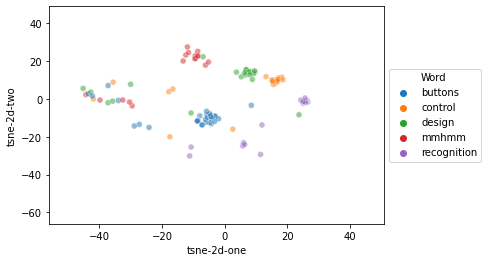

In [49]:
word_list = ["mmhmm", "buttons", "control", "design", "recognition"]
visualize_words(word_list,tsne_vectors,labels, rigid_limits = True)

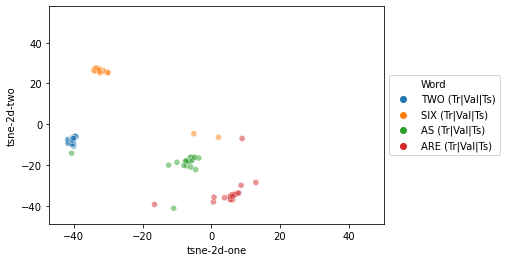

In [102]:
word_list = ["AS","ARE","TWO","SIX"]
visualize_words(word_list,tsne_vectors,labels,True)

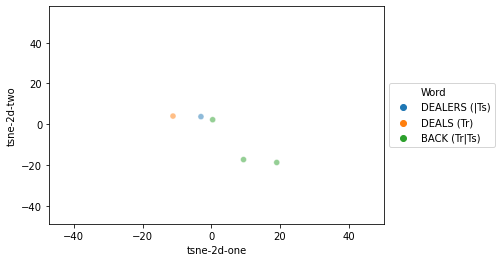

In [103]:
word_list = ["DEALERS","DEALS","BACK"]
visualize_words(word_list,tsne_vectors,labels,True)

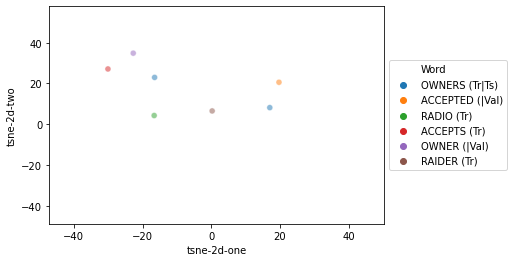

In [104]:
word_list = ["ACCEPTED","ACCEPTS","RADIO","RAIDER","OWNER","OWNERS"]
visualize_words(word_list,tsne_vectors,labels,True)

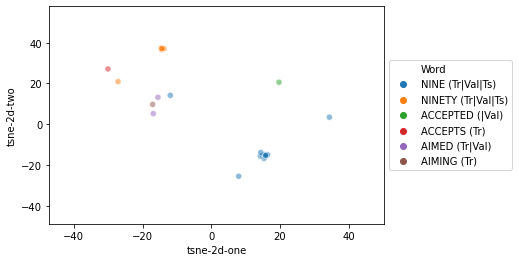

In [105]:
word_list = ["NINE","NINETY","ACCEPTED","ACCEPTS","AIMED","AIMING"]
visualize_words(word_list,tsne_vectors,labels,True)

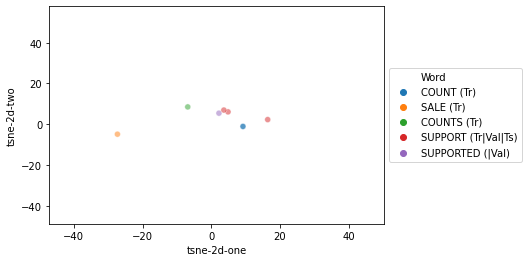

In [106]:
word_list = ["COUNT","COUNTS","SALE","SUPPORT","SUPPORTED"]
visualize_words(word_list,tsne_vectors,labels,True)

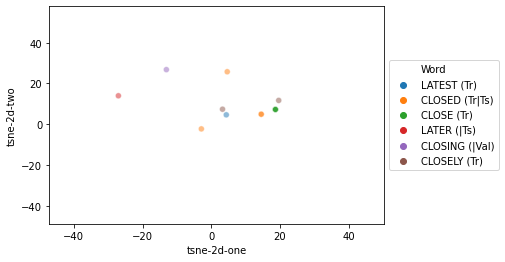

In [107]:
word_list = ["LATER","LATEST","CLOSE","CLOSING","CLOSED","CLOSELY"]
visualize_words(word_list,tsne_vectors,labels,True)

In [114]:
distances,indices = nearest_neighbors(net,torch.tensor(inputs,dtype=torch.float),labels,n_neighbors=5)

In [115]:
word = "SUPPORT"
nearest_neighbors_for_word(word,indices,labels)

['SUPPORT', 'CLIMB', 'PROBABLY', 'AIRCRAFT', 'DIRECT']
['SUPPORT', 'OPERATOR', 'AIRCRAFT', 'HOLDING', 'SHARES']
['LIKELY', 'COMING', 'OPERATOR', 'SHARES', 'SURPRISE']


In [116]:
word = "LATER"
nearest_neighbors_for_word(word,indices,labels)

['LATER', 'UNDER', 'HUNDRED', 'UNDER', 'HUNDRED']


In [117]:
word = "CLOSING"
nearest_neighbors_for_word(word,indices,labels)

['CLOSING', 'WASHINGTON', 'AFTER', 'OPPOSITION', 'COMMENT']


In [118]:
word = "ACCEPTED"
nearest_neighbors_for_word(word,indices,labels)

['ACCEPTED', 'INFLATION', 'PURCHASES', 'PROCESS', 'SPLIT']


In [119]:
word = "DEALS"
nearest_neighbors_for_word(word,indices,labels)

['DEALS', 'PUBLICLY', 'FINANCIAL', 'FINANCIAL', 'EXPOSURE']


In [120]:
word = "ACCEPTS"
nearest_neighbors_for_word(word,indices,labels)

['ACCEPTS', 'SIX', 'BUSINESS', 'SIX', 'SINCE']


In [121]:
word = "DAY"
nearest_neighbors_for_word(word,indices,labels)

['DAY', 'MAY', 'MAY', 'MAY', 'EIGHT']
['DAY', 'BIDS', 'MAY', 'DAY', 'BASED']
['DAY', 'DAY', 'MAY', 'BIDS', 'BASED']
['DAY', 'YOU', 'HUNDRED', 'UNDER', 'CLEAR']


In [122]:
word = "DEALERS"
nearest_neighbors_for_word(word,indices,labels)

['DEALERS', 'LANGUAGE', 'GROUP', 'TOO', 'PREVIOUS']


In [50]:
from sklearn.metrics import average_precision_score

In [52]:
y_test = np.hstack((np.ones((100000)), np.zeros(60000000)))
y_pred = np.zeros(60100000)

average_precision_score(y_test,y_pred)


0.0016638935108153079